# Задание 1. A/B-тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [33]:
# Импортируем библиотеки 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import pingouin as pg
import scipy.stats as stats
from scipy.stats import norm
from tqdm.auto import tqdm

import requests
from urllib.parse import urlencode

In [34]:
def get_data(yandex_link, sep=','):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = yandex_link
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return pd.read_csv(download_url, sep=sep)

In [35]:
# Загружаем DataFrames
# основная таблица с пользователями
groups = get_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
# дополнительный файл с пользователями
groups_add = get_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
# файл с активными пользователями
active_studs = get_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', sep=';')
# файл об оплатах пользователей
checks = get_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')

## EDA

Входные данные:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа);
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных;
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента;
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Предварительно исследуем данные.


In [36]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [37]:
# прощуенных значений нет
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [38]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [39]:
# прощуенных значений нет
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [40]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [41]:
# прощуенных значений нет
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [42]:
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [43]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [44]:
# прощуенных значений нет
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [45]:
checks = checks.rename(columns={'student_id': 'id'})
# переведем выручку в int
checks['rev'] = checks['rev'].astype(int)

In [46]:
# Объединяем основной и дополнительные файлы
experiments = pd.concat([groups, groups_add], ignore_index=True)

In [47]:
# Проверяем таблицу на наличие повторяющихся значений в id
experiments['id'].duplicated().sum()

0

Дубликаты в таблице experiments отсутствуют, следовательно, каждый из пользователей мог зайти на платформу не более одного раза.

In [48]:
# Добавим к таблице с информацией о пользовательх таблицы active_studs и checks
experiments = experiments.merge(active_studs, how='inner', on='id')
experiments = experiments.merge(checks, how='left', on='id')
experiments['rev'] = experiments.rev.fillna(0)

experiments.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


В результате у нас получилась таблица содержащая информацию о пользователях контрольной и экспериментальной групп, которые были активны во время проведения эксперимента. Такие пользователи как совершали покупки на платформе, так и не совершали. Пользователи, которые во время A/B-теста не были активны, нас не интересуют, поскольку не позволяют оценить эффективность новой механики. Также в данных были обнаружены неактивные пользователи, имеющие покупки во время проведения эксперимента. Данные пользователи нас тоже не интересуют, поскольку их покупки - это списание средств за подписку на платформе. Ранее оформленные подписки нам так же не позволяют оценить эффективность новой механики.

In [49]:
# Добавим данные purchases в таблице, где: 0 - пользователь не совершал покупок; 1 - пользователь совершил покупку
experiments['purchases'] = np.where(experiments['rev'] > 0, 1, 0)

In [50]:
experiments.head()

,id,grp,rev,purchases
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


## Метрики и A/B-тестирование 

В качестве интересующих нас показателей выберем следующие:

- Conversion Rate - отношение пользователей, совершивших покупку, ко всем активынм пользователям во время эксперимента;
- ARPPU - Средний доход на платящего пользователя (то есть клиента).
- ARPU - Cредний доход с привлечённого пользователя.

Данные метрики позволяет оценить эффективность новой механики оплаты и на основании результатов A/B-теста сделать выводы о статистичесих различиях 

In [51]:
# Рассчитаем метрики
metric = (
    experiments.groupby('grp', as_index=False)
    .agg({'id': 'count', 'rev': 'sum', 'purchases': 'sum'})
    .rename(columns={'id': 'active_students', 'rev': 'total_revenue'}))
metric = (
    metric.assign(
        ARPU=round(metric.total_revenue / metric.active_students, 2), 
        ARPPU=round(metric.total_revenue / metric.purchases, 2), 
        CR=round(metric.purchases / metric.active_students * 100, 2))
)
metric

,grp,active_students,total_revenue,purchases,ARPU,ARPPU,CR
0,A,1538,72820.0,78,47.35,933.59,5.07
1,B,6803,394974.0,314,58.06,1257.88,4.62


In [52]:
# Вычислим количество наблюдений в контрольной и тестовых группах
control = experiments[experiments['grp'] == 'A']
treatment = experiments[experiments['grp'] == 'B']


print(f'Количество наблюдений в контрольной группе: {control.id.count()}')
print(f'Количество наблюдений в тестовой группе: {treatment.id.count()}')

Количество наблюдений в контрольной группе: 1538
Количество наблюдений в тестовой группе: 6803


In [53]:
# Проверим распределения на нормальность
pg.normality(experiments, dv='rev', group='grp')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
grp,,,
A,0.154167,0.0,False
B,0.181245,0.0,False


In [54]:
# Проверим равенство критериев
pg.homoscedasticity(experiments, dv='rev', group='grp')

,W,pval,equal_var
levene,1.501461,0.220481,True


Ненормальность распределения снижает точность A/B-теста, однако равенство дисперсии позволяет сравнивать интересующие нас метрики. В качестве методов проведения A/B-тестов будет использовать t-test и bootstrap (примеч. можно было бы обойтись лишь одним t-test, который эффективен в том числе и на ненормальных распределения, однако для большей уверенности применим и bootstrap). Предварительно посмотрим на распределения: CR, ARPPU

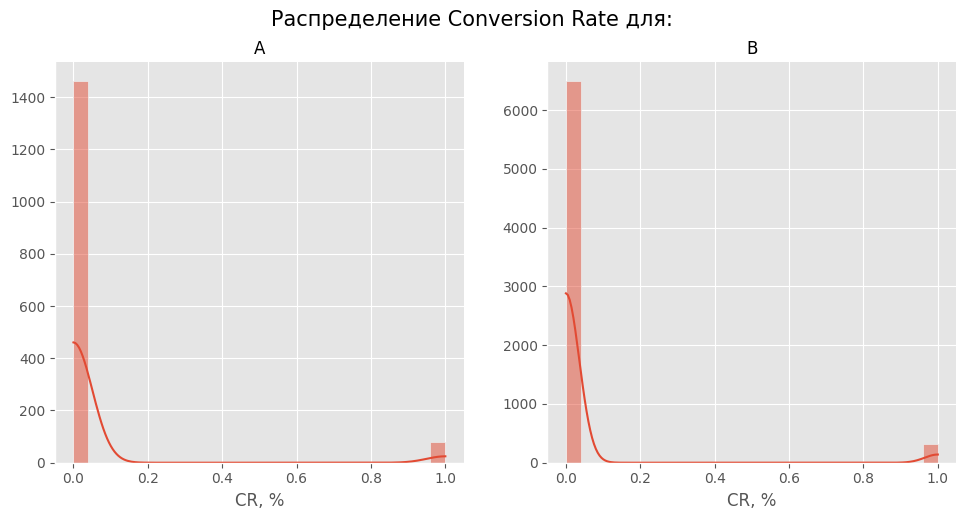

In [55]:
g = sns.FacetGrid(data=experiments, col='grp', col_wrap=2, height=5, sharex=False, sharey=False)
g.map(sns.histplot, 'purchases', kde=True, bins=25)
g.set_axis_labels('СR, %', '')
g.fig.suptitle('Распределение Сonversion Rate для:', y=1.03, fontsize=15)
g.set_titles(col_template='{col_name}', row_template='{row_name}')

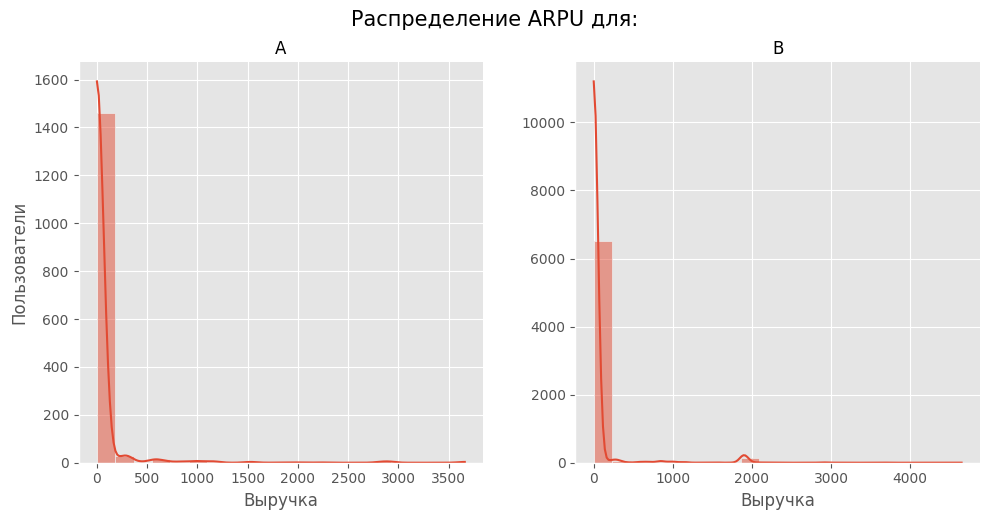

In [56]:
g = sns.FacetGrid(data=experiments, col='grp', col_wrap=2, height=5, sharex=False, sharey=False)
g.map(sns.histplot, 'rev', kde=True, bins=20)
g.set_axis_labels('Выручка', 'Пользователи')
g.fig.suptitle('Распределение ARPU для:', y=1.03, fontsize=15)
g.set_titles(col_template='{col_name}', row_template='{row_name}')

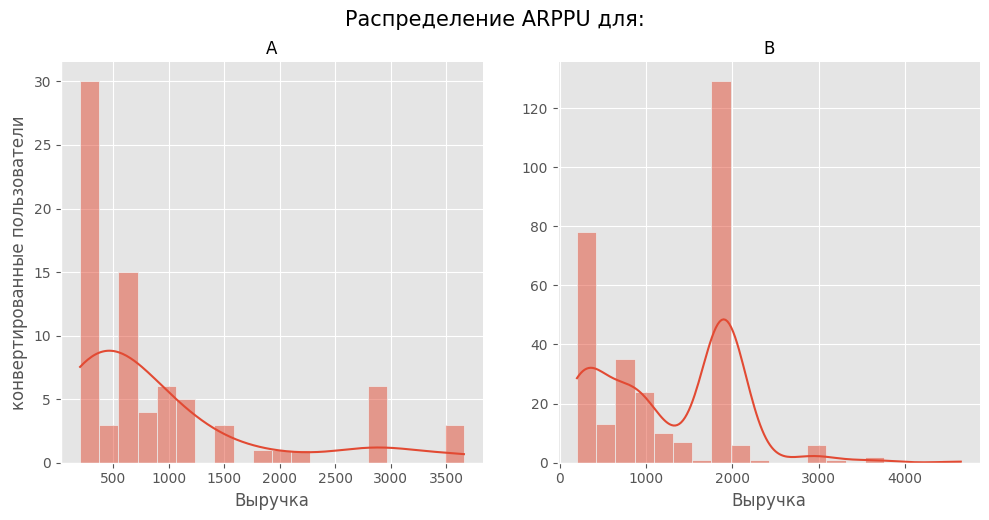

In [57]:
g = sns.FacetGrid(data=experiments[experiments['rev'] > 0], col='grp', col_wrap=2, height=5, sharex=False, sharey=False)
g.map(sns.histplot, 'rev', kde=True, bins=20)
g.set_axis_labels('Выручка', 'конвертированные пользователи')
g.fig.suptitle('Распределение ARPPU для:', y=1.03, fontsize=15)
g.set_titles(col_template='{col_name}', row_template='{row_name}')

Нормальность распределения важна в случае использования t-test, однако не является обязательным требованием к его использованию, таким образом, мы его вполне можем использовать.
В качестве основной метрики будем использовать Converrsion Rate, исходя из этого сформулируем гипотезы:

- H0: Разницы между CR в тестовой и контрольной группах нет.
- H1: Разницы между CR в тестовой и контрольной группах есть.

Также дополнительно сравним контрольную и тестовую группу по метрикам - ARPU и ARPPU.

In [58]:
# Conversion 
conversion_control = control['purchases']
conversion_treatment = treatment['purchases']
test_stat, pvalue = stats.ttest_ind(conversion_control, conversion_treatment)
if pvalue >= 0.05:
    print(f'Conversion Rate: t-статистика = {test_stat:0.4f}, p-value = {pvalue:0.4f} H0 отклонить не можем.')
else:
    print(f'Conversion Rat: t-статистика = {test_stat:0.4f}, p-value = {pvalue:0.4f} отклоняем нулевую гипотезу.')

# ARPU
ARPU_control = control['rev']
ARPU_treatment = treatment['rev']
test_stat, pvalue = stats.ttest_ind(ARPU_control, ARPU_treatment)
if pvalue >= 0.05:
    print(f'ARPU: t-статистика = {test_stat:0.4f}, p-value = {pvalue:0.4f} H0 отклонить не можем.')
else:
    print(f'ARPU: t-статистика = {test_stat:0.4f}, p-value = {pvalue:0.4f} отклоняем нулевую гипотезу.')

# ARPPU
ARPPU_control = control[control['rev'] > 0].rev
ARPPU_treatment = treatment[treatment['rev'] > 0].rev
test_stat, pvalue = stats.ttest_ind(ARPPU_control, ARPPU_treatment)
if pvalue >= 0.05:
    print(f'ARPPU: t-статистика = {test_stat:0.4f}, p-value = {pvalue:0.4f} H0 отклонить не можем.')
else:
    print(f'ARPPU: t-статистика = {test_stat:0.4f}, p-value = {pvalue:0.4f} отклоняем нулевую гипотезу.')


Conversion Rate: t-статистика = 0.7629, p-value = 0.4455 H0 отклонить не можем.
ARPU: t-статистика = -1.2253, p-value = 0.2205 H0 отклонить не можем.
ARPPU: t-статистика = -3.1338, p-value = 0.0019 отклоняем нулевую гипотезу.


Провдем A/B-тест при помощи bootstrap. Его достоинство состоит в том, что bootstrap проверяет статистические гипотезы без опоры на определённое теоретическое распределение данных (в отличие от классических статистических критериев).

In [59]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.9
    ):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|██████████| 1000/1000 [00:00<00:00, 11453.06it/s]


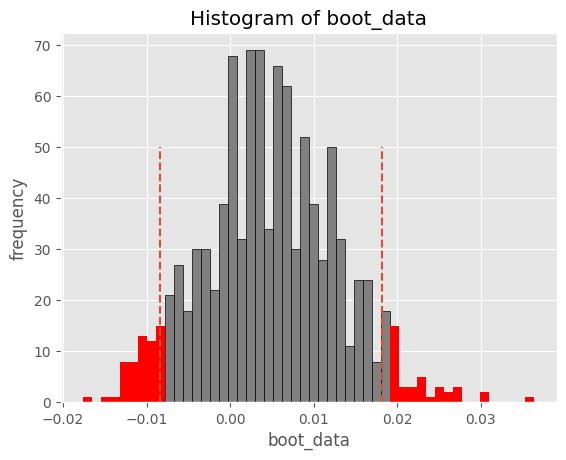

100%|██████████| 1000/1000 [00:00<00:00, 11728.15it/s]


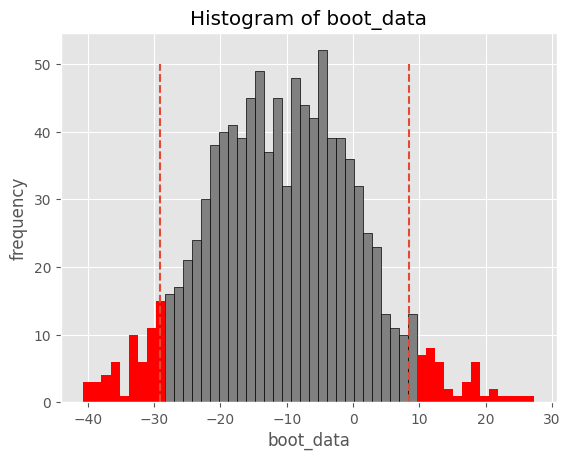

100%|██████████| 1000/1000 [00:00<00:00, 21972.71it/s]


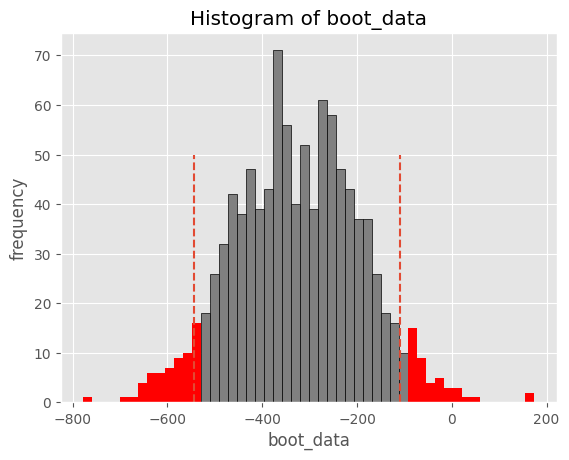

In [60]:
# Bootstrap metrics
booted_CR = get_bootstrap(conversion_control, conversion_treatment)
booted_ARPU = get_bootstrap(ARPU_control, ARPU_treatment)
booted_ARPPU = get_bootstrap(ARPPU_control, ARPPU_treatment)

In [61]:
print('Conversion Rate =', round(booted_CR['p_value'], 4))
print('ARPU =', round(booted_ARPU['p_value'], 4))
print('ARPPU =', round(booted_ARPPU['p_value'], 4))

Conversion Rate = 0.5515
ARPU = 0.3533
ARPPU = 0.0151


Проверим систему сплитования с помощью A/A-теста (A/A-тест проводят перед сплитованием пользователей на контроль/тест, чтобы убедиться, что в система сплитования работает корректно, однако мы проведем ее, чтобы убедиться в корректности A/B-теста). Для этого отберем пользователей, принадлежащих только контрольной группе. При этом будем учитывать не только активных во время A/B-теста пользователей, но и не активных. 

In [62]:
control_aa = pd.concat([groups, groups_add], ignore_index=True)
control_aa = control_aa.merge(checks, how='left', on='id')
control_aa['rev'] = control_aa.rev.fillna(0)
control_aa = control_aa[control_aa['grp'] == 'A']
control_aa['purchases'] = np.where(control_aa['rev'] > 0, 1, 0)

100%|██████████| 1000/1000 [00:00<00:00, 2436.94it/s]


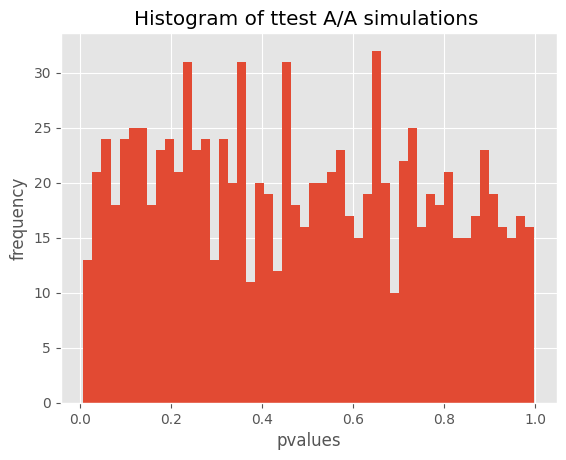

0.038

In [63]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = control_aa['rev'].sample(n_s, replace=False).values
    s2 = control_aa['rev'].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

100%|██████████| 1000/1000 [00:00<00:00, 2450.11it/s]


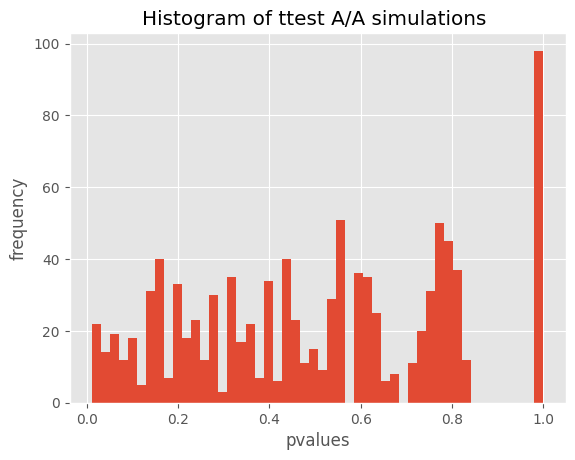

0.036

In [64]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = control_aa['purchases'].sample(n_s, replace=False).values
    s2 = control_aa['purchases'].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Исходя из результатов А/А-теста (FPR < α), можно сделать вывод, что система сплитования работала корренктно, однако смотря на распределение второго A/A-теста, можно наблюдать скошенное вправо распределение, что может говорить об ошибках в сплитовании. 

## Результат и выводы

Результаты t-test и bootstrap указывают на то, что нулевую гипотезу (H0: Разницы между CR в тестовой и контрольной группах нет) мы отклонить не можем, таким образом, в данный момент новую механику оплаты не стоит запускать на всех пользователей. Это же подтверждает и метрика ARPU. Что касается метрики ARPPU, то разница между исследуемыми группами могла возникнуть в результате аномалий в тестовой группе.

В качестве решения проблемы необходимо проверить систему сплитования и устранить ошибки в случае их обнаружения, в том числе необходимо снизить диспропорцию выборок (в тестовой группе оказалось 80% всех пользователей, участвующих в эксперименте, что существенно виляет на эффективность эксперимента). После провести новый А/B-тест или A/A/B-тест (однако второй требует больше времени, трафика и мощностей). В данный момент запускать новую механику оплаты не будем.